In [479]:
!pip install torch_geometric

In [480]:
upload_method = 1 # 0:through google drive; 1:through local
if upload_method == 0:
  from google.colab import drive
  drive.mount("/content/drive")
  data_file = '/content/drive/MyDrive/PhD thesis/Kronecker GCN proof/data/link_prediction/DDI_100_nodes.pkl'
  with open(data_file, 'rb') as f:
    loaded_dict = pickle.load(f)
else:
  import pickle
  from google.colab import files
  # upload DDI_100_nodes.pkl
  uploaded = files.upload()
  for name, data in uploaded.items():
    with open(name, 'rb') as f:
      loaded_dict = pickle.load(f)

Saving DDI_100_nodes.pkl to DDI_100_nodes (9).pkl


In [481]:
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import negative_sampling
import random
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

In [482]:
random.seed(0)
random.random()

torch.manual_seed(0)
torch.rand(4)

np.random.seed(0)
np.random.rand(4)

array([0.5488135 , 0.71518937, 0.60276338, 0.54488318])

In [483]:
graph_origin = loaded_dict
xx  = torch.stack(list(loaded_dict.edge_index), dim=0)
graph_origin.edge_index = xx

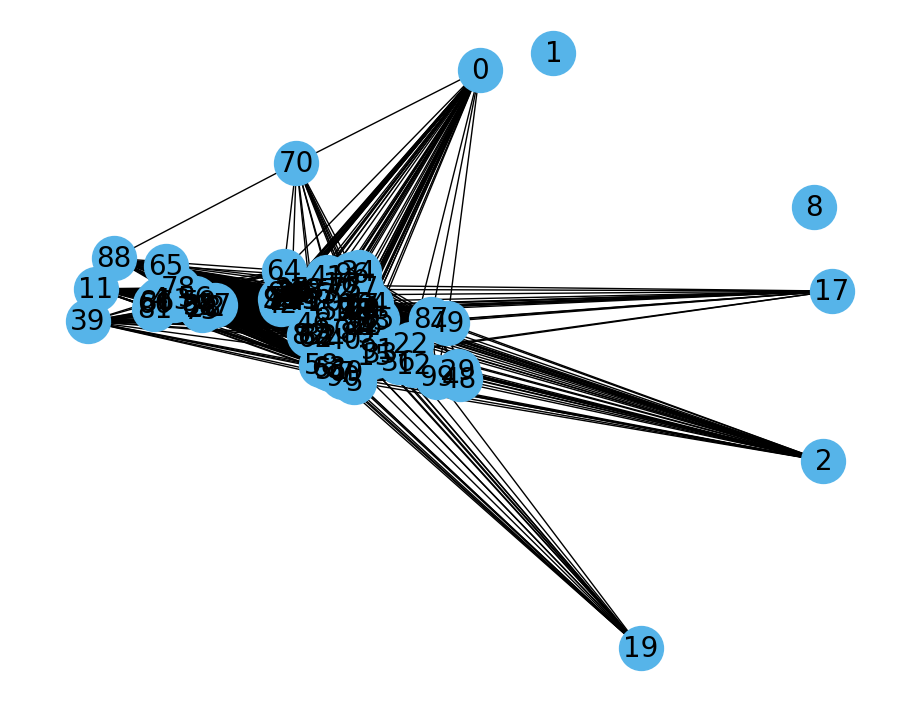

In [484]:
def convert_to_networkx(graph):

    g = to_networkx(graph, node_attrs=["x"])

    return g


def plot_graph(g):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, with_labels=True, node_color='#56b4e9', node_size=1000, arrows=False, font_size=20)
    plt.show()


g_origin = convert_to_networkx(graph_origin)
plot_graph(g_origin)

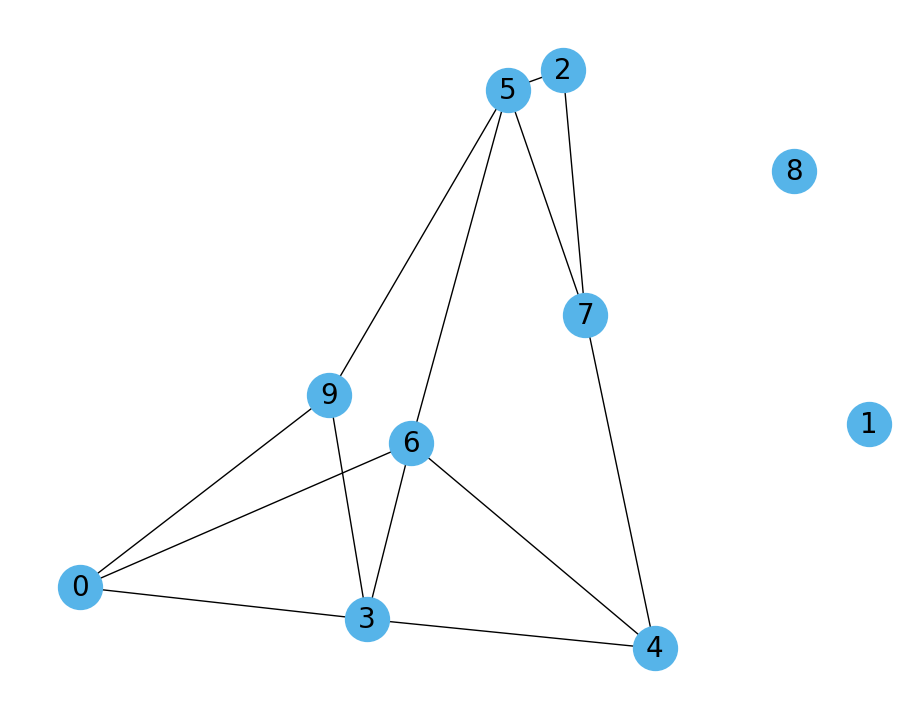

In [485]:
t = np.arange(0, 10, 1)
g = g_origin.subgraph(t)
plot_graph(g)

In [486]:
from torch_geometric.utils.convert import from_networkx
graph_directed = from_networkx(
    G=g
)

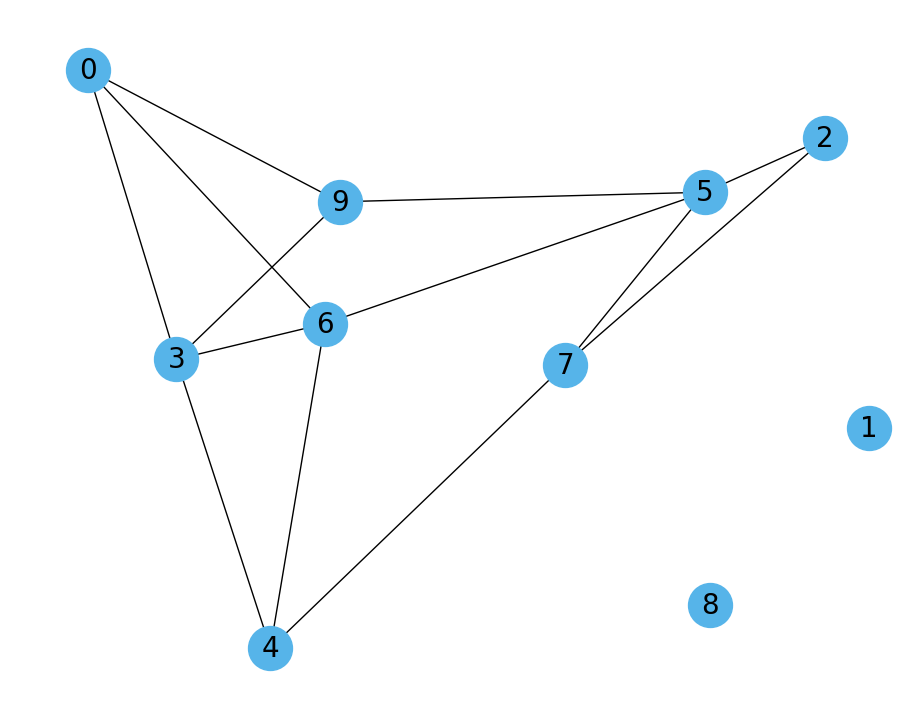

In [487]:
g_sub = convert_to_networkx(graph_directed)
plot_graph(g_sub)

In [488]:
def plot_graph_circle(g):
    G = nx.complete_graph(len(g.nodes))
    plt.figure(figsize=(9, 7))
    nx.draw(g, with_labels=True, node_color='#56b4e9', node_size=1000, arrows=False, font_size=20, pos=nx.spring_layout(G, seed=0))
    plt.show()

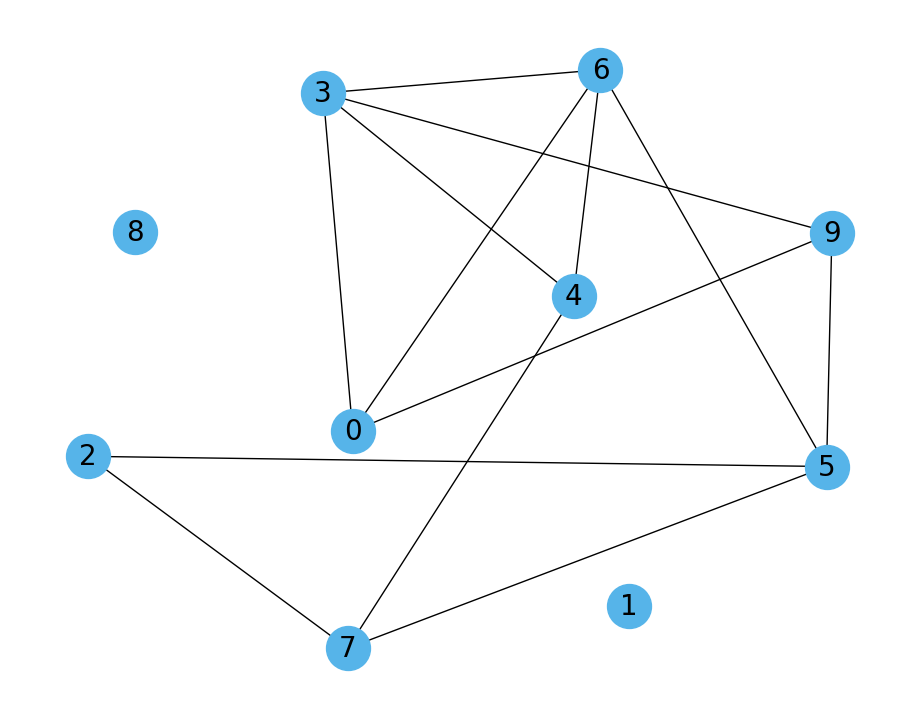

In [489]:
plot_graph_circle(g_sub)

In [490]:
from torch_geometric.transforms.to_undirected import ToUndirected
graph = ToUndirected()(graph_directed)

In [491]:
def my_loss(output, target, target_neg):

  # ct = 1e-15 # to deal with log(0)
  A=((to_dense_adj(target, max_num_nodes=10)>0)*1)[0]
  B=((to_dense_adj(target_neg, max_num_nodes=10)>0)*1)[0]
  mask = A+B
  # loss_true = -sum(sum(A*torch.log(output+ct)))
  # loss_mis = -sum(sum(B*torch.log(1-output+ct)))
  loss_true = -sum(sum(A*torch.log(output)))
  loss_mis = -sum(sum(B*torch.log(1-output)))
  loss = (loss_true + loss_mis)/mask.sum()

  return loss

In [492]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.gcn = GCNConv(dataset.num_features, 3)
        # self.out = Linear(dataset.num_classes, dataset.num_classes)
        # self.gcn = GCNConv(dataset.num_features, dataset.num_classes)
        self.num_features = 20
        self.num_hiddens_1 = 10
        self.num_hiddens_2 = 5
        self.FCL1 = nn.Linear(self.num_features, self.num_hiddens_1, bias=False)
        self.FCL2 = nn.Linear(self.num_hiddens_1, self.num_hiddens_2, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        D = torch.diag(sum(temp_A)+1).float()
        D_inv = torch.inverse(torch.sqrt(D))
        A=((to_dense_adj(edge_index, max_num_nodes=10)>0)*1)[0].numpy().astype(int)
        A_hat = torch.from_numpy(A).float()+torch.eye(10)
        temp = D_inv@A_hat@D_inv@x
        h1 = self.relu(self.FCL1(temp)) # y = xW'
        temp2 = D_inv@A_hat@D_inv@h1
        h2 = self.FCL2(temp2)
        h3 = h2@h2.t()
        z = self.sigmoid(h3)
        return h1, h2, h3, z

In [493]:
# import torch_geometric.transforms as T

# split = T.RandomLinkSplit(
#     num_val=0.05,
#     num_test=0.1,
#     is_undirected=True,
#     add_negative_train_samples=False,
#     neg_sampling_ratio=1.0,
# )
# train_data, val_data, test_data = split(graph)

train_data = graph

temp_A=((to_dense_adj(train_data.edge_index, max_num_nodes=10)>0)*1)[0]
train_edge_index = temp_A.nonzero().t().contiguous()
train_edge_label = torch.ones(train_edge_index[0].size())

In [494]:
train_edge_index

tensor([[0, 0, 0, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 9,
         9, 9],
        [3, 6, 9, 5, 7, 0, 4, 6, 9, 3, 6, 7, 2, 6, 7, 9, 0, 3, 4, 5, 2, 4, 5, 0,
         3, 5]])

In [495]:
train_data.edge_index.size(1)

26

In [496]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel = GCN().to(device)
count = 0
for name, param in mymodel.named_parameters():
    if param.requires_grad:
        if count == 0:
          W1 = param.data.detach().clone()
          W1_peak = param.data
        else:
          W2 = param.data.detach().clone()
          W2_peak = param.data
        print(name, param.numel())
        count = count + 1

FCL1.weight 200
FCL2.weight 50


In [497]:
W1.data

tensor([[-0.0861,  0.0600, -0.0044,  0.1773, -0.0198,  0.0592, -0.0676, -0.0440,
         -0.2136, -0.1481, -0.0922,  0.0083,  0.0884,  0.1342, -0.1516, -0.0974,
          0.0812,  0.1857, -0.0460,  0.1673],
        [-0.0360,  0.0237,  0.2025, -0.2074, -0.1408, -0.0566, -0.0872,  0.1932,
         -0.1449, -0.1029, -0.1562, -0.2094, -0.1305,  0.1922,  0.0998,  0.1084,
          0.0118, -0.1146,  0.0378, -0.2088],
        [-0.1616, -0.1153,  0.1411,  0.1311, -0.0992, -0.0081,  0.1430,  0.2223,
          0.0887,  0.0302,  0.1499, -0.1317,  0.0417, -0.1734, -0.1550, -0.1155,
          0.1012,  0.0899, -0.1325,  0.0676],
        [ 0.1228, -0.0282,  0.0085,  0.0518,  0.1387,  0.2147, -0.1723, -0.0819,
          0.0879,  0.1853,  0.1946,  0.1973,  0.0445, -0.1944,  0.0206, -0.1399,
         -0.2084,  0.1987,  0.1700, -0.2231],
        [ 0.0419, -0.0377, -0.0368, -0.1024,  0.0860, -0.1324,  0.0820,  0.1131,
          0.1601,  0.0836, -0.2213, -0.1451,  0.1117,  0.0468, -0.1744, -0.1288,
      

In [498]:
W2.data

tensor([[-0.1836,  0.2213, -0.1137,  0.2667,  0.1144,  0.0400, -0.0024, -0.0625,
          0.0397, -0.0722],
        [-0.0022,  0.0403, -0.2474, -0.1657,  0.2554, -0.2566, -0.0227,  0.3128,
          0.1142,  0.0090],
        [-0.2740,  0.1567, -0.2252, -0.0898, -0.1061, -0.0468,  0.0035,  0.2608,
          0.0395,  0.2832],
        [ 0.1934, -0.1999,  0.1418, -0.2235, -0.1340,  0.0930,  0.1044,  0.2372,
         -0.1018,  0.0005],
        [ 0.1628, -0.3058,  0.2286, -0.2615,  0.0044, -0.0538, -0.1665,  0.0418,
          0.2615, -0.0924]])

In [499]:
n_epochs = 150
# criterion = torch.nn.BCEWithLogitsLoss()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# mymodel = GCN().to(device)
lr=0.01
optimizer = torch.optim.SGD(params=mymodel.parameters(), lr=lr)
W1_change = []
W1_change.append(W1_peak.detach().clone())
W2_change = []
W2_change.append(W2_peak.detach().clone())
neg_samples_list = []
outputs = []
losses = []

# save initial data
mymodel.eval()
with torch.no_grad():
    # sampling training negatives for every training epoch
    neg_edge_index = negative_sampling(
        edge_index=train_edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_index.size(1), method='sparse')

    neg_samples_list.append(neg_edge_index)

    temp_B=((to_dense_adj(neg_edge_index, max_num_nodes=10)>0)*1)[0]
    re_neg_edge_index = temp_B.nonzero().t().contiguous()

    edge_label_index = torch.cat(
        [train_edge_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_edge_label,
        train_edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    h1, h2, h3, out = mymodel(train_data.x, train_data.edge_index)
    loss = my_loss(out, train_data.edge_index, neg_edge_index)
    outputs.append(out)
    losses.append(loss)
mymodel.train(True)

for epoch in range(1, n_epochs + 1):

    mymodel.train()
    optimizer.zero_grad()

    # sampling training negatives for every training epoch
    neg_edge_index = negative_sampling(
        edge_index=train_edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_index.size(1), method='sparse')

    neg_samples_list.append(neg_edge_index)

    temp_B=((to_dense_adj(neg_edge_index, max_num_nodes=10)>0)*1)[0]
    re_neg_edge_index = temp_B.nonzero().t().contiguous()

    edge_label_index = torch.cat(
        [train_edge_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_edge_label,
        train_edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    h1, h2, h3, out = mymodel(train_data.x, train_data.edge_index)
    loss = my_loss(out, train_data.edge_index, neg_edge_index)

    loss.backward()
    optimizer.step()

    W1_change.append(W1_peak.detach().clone())
    W2_change.append(W2_peak.detach().clone())

    outputs.append(out)
    losses.append(loss)

    # val_auc = accuracy(mymodel, val_data)
    # val_auc = 0

    if epoch % 1 == 0:
        print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}")

Epoch: 001, Train Loss: 0.681
Epoch: 002, Train Loss: 0.697
Epoch: 003, Train Loss: 0.701
Epoch: 004, Train Loss: 0.682
Epoch: 005, Train Loss: 0.711
Epoch: 006, Train Loss: 0.711
Epoch: 007, Train Loss: 0.685
Epoch: 008, Train Loss: 0.677
Epoch: 009, Train Loss: 0.689
Epoch: 010, Train Loss: 0.679
Epoch: 011, Train Loss: 0.693
Epoch: 012, Train Loss: 0.702
Epoch: 013, Train Loss: 0.687
Epoch: 014, Train Loss: 0.677
Epoch: 015, Train Loss: 0.673
Epoch: 016, Train Loss: 0.704
Epoch: 017, Train Loss: 0.703
Epoch: 018, Train Loss: 0.676
Epoch: 019, Train Loss: 0.688
Epoch: 020, Train Loss: 0.662
Epoch: 021, Train Loss: 0.694
Epoch: 022, Train Loss: 0.677
Epoch: 023, Train Loss: 0.703
Epoch: 024, Train Loss: 0.675
Epoch: 025, Train Loss: 0.678
Epoch: 026, Train Loss: 0.703
Epoch: 027, Train Loss: 0.691
Epoch: 028, Train Loss: 0.686
Epoch: 029, Train Loss: 0.683
Epoch: 030, Train Loss: 0.650
Epoch: 031, Train Loss: 0.654
Epoch: 032, Train Loss: 0.686
Epoch: 033, Train Loss: 0.668
Epoch: 034

In [500]:
train_data.edge_index

tensor([[0, 0, 0, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 9,
         9, 9],
        [3, 6, 9, 5, 7, 0, 4, 6, 9, 3, 6, 7, 2, 6, 7, 9, 0, 3, 4, 5, 2, 4, 5, 0,
         3, 5]])

In [501]:
neg_edge_index

tensor([[5, 0, 0, 8, 2, 8, 0, 7, 6, 6, 9, 3, 4, 1, 9, 8, 8, 3, 6, 1, 1, 5, 5, 2,
         8, 8],
        [4, 1, 5, 1, 4, 4, 2, 1, 7, 9, 8, 8, 8, 4, 2, 2, 6, 5, 2, 9, 6, 3, 1, 3,
         5, 3]])

In [502]:
loss.dtype

torch.float32

In [503]:
W1_change

[tensor([[-0.0861,  0.0600, -0.0044,  0.1773, -0.0198,  0.0592, -0.0676, -0.0440,
          -0.2136, -0.1481, -0.0922,  0.0083,  0.0884,  0.1342, -0.1516, -0.0974,
           0.0812,  0.1857, -0.0460,  0.1673],
         [-0.0360,  0.0237,  0.2025, -0.2074, -0.1408, -0.0566, -0.0872,  0.1932,
          -0.1449, -0.1029, -0.1562, -0.2094, -0.1305,  0.1922,  0.0998,  0.1084,
           0.0118, -0.1146,  0.0378, -0.2088],
         [-0.1616, -0.1153,  0.1411,  0.1311, -0.0992, -0.0081,  0.1430,  0.2223,
           0.0887,  0.0302,  0.1499, -0.1317,  0.0417, -0.1734, -0.1550, -0.1155,
           0.1012,  0.0899, -0.1325,  0.0676],
         [ 0.1228, -0.0282,  0.0085,  0.0518,  0.1387,  0.2147, -0.1723, -0.0819,
           0.0879,  0.1853,  0.1946,  0.1973,  0.0445, -0.1944,  0.0206, -0.1399,
          -0.2084,  0.1987,  0.1700, -0.2231],
         [ 0.0419, -0.0377, -0.0368, -0.1024,  0.0860, -0.1324,  0.0820,  0.1131,
           0.1601,  0.0836, -0.2213, -0.1451,  0.1117,  0.0468, -0.1744, -

In [504]:
W2_change[0][0][0].item()

-0.18362130224704742

In [505]:
W2_change

[tensor([[-0.1836,  0.2213, -0.1137,  0.2667,  0.1144,  0.0400, -0.0024, -0.0625,
           0.0397, -0.0722],
         [-0.0022,  0.0403, -0.2474, -0.1657,  0.2554, -0.2566, -0.0227,  0.3128,
           0.1142,  0.0090],
         [-0.2740,  0.1567, -0.2252, -0.0898, -0.1061, -0.0468,  0.0035,  0.2608,
           0.0395,  0.2832],
         [ 0.1934, -0.1999,  0.1418, -0.2235, -0.1340,  0.0930,  0.1044,  0.2372,
          -0.1018,  0.0005],
         [ 0.1628, -0.3058,  0.2286, -0.2615,  0.0044, -0.0538, -0.1665,  0.0418,
           0.2615, -0.0924]]),
 tensor([[-1.8374e-01,  2.2106e-01, -1.1393e-01,  2.6691e-01,  1.1435e-01,
           3.9671e-02, -2.7671e-03, -6.2653e-02,  3.9581e-02, -7.2370e-02],
         [-2.0951e-03,  4.0693e-02, -2.4722e-01, -1.6555e-01,  2.5541e-01,
          -2.5634e-01, -2.2401e-02,  3.1317e-01,  1.1436e-01,  9.1869e-03],
         [-2.7416e-01,  1.5662e-01, -2.2544e-01, -9.0020e-02, -1.0614e-01,
          -4.7251e-02,  3.0408e-03,  2.6058e-01,  3.9427e-02,  2.8

In [506]:
h1

tensor([[0.0000, 0.0000, 0.0000, 3.4260, 0.0000, 0.0000, 0.0000, 0.0000, 0.0537,
         0.0331],
        [2.2645, 1.2744, 3.2517, 0.0000, 0.0000, 2.9290, 3.3465, 1.9293, 0.6851,
         0.0000],
        [0.7618, 0.0362, 1.1145, 0.0000, 0.2862, 0.5400, 1.1324, 1.3700, 0.7229,
         0.0000],
        [0.0000, 0.3497, 0.0000, 1.9532, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.8452, 0.5460, 0.0000, 0.0000, 0.0000, 0.0000,
         0.3581],
        [0.0000, 0.0000, 0.1664, 1.4846, 0.2534, 0.0000, 0.0000, 0.2692, 0.8151,
         0.0344],
        [0.3574, 0.9286, 0.0000, 1.0286, 0.0000, 0.9540, 0.5667, 0.2636, 0.0000,
         0.0000],
        [1.3483, 0.7570, 0.2931, 0.0000, 0.2854, 1.3045, 0.8841, 1.3786, 0.0000,
         0.0000],
        [0.0000, 1.6956, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.1237,
         3.5088],
        [0.0000, 0.1054, 0.2704, 1.6946, 0.0000, 0.0000, 0.2361, 0.7593, 0.2435,
         0.0000]], grad_fn=<

In [507]:
h2

tensor([[ 0.7285, -0.2959, -0.2967, -0.5571, -0.6394],
        [-0.8961, -0.5114, -0.8426,  1.4788,  0.9169],
        [-0.0572,  0.1653, -0.1483,  0.2477,  0.2038],
        [ 0.8910, -0.3446, -0.3737, -0.7086, -0.7737],
        [ 0.4795, -0.1517, -0.2439, -0.2993, -0.4690],
        [ 0.1680,  0.0652, -0.1790,  0.0637, -0.0365],
        [ 0.8767, -0.3375, -0.3829, -0.7293, -0.7200],
        [ 0.2180,  0.0539, -0.2495, -0.0206, -0.0490],
        [-0.1850,  0.3669,  1.4271, -0.3677, -0.2241],
        [ 0.7517, -0.2488, -0.3206, -0.6072, -0.5543]], grad_fn=<MmBackward0>)

In [508]:
h3

tensor([[ 1.4256, -1.6616, -0.3149,  1.7514,  0.9332,  0.1441,  1.7189,  0.2598,
         -0.3187,  1.4091],
        [-1.6616,  4.8018,  0.6448, -2.0644, -1.0192,  0.0276, -2.0291, -0.0881,
         -1.9736, -1.6823],
        [-0.3149,  0.6448,  0.1555, -0.3857, -0.1861,  0.0360, -0.3766,  0.0183,
         -0.2772, -0.2999],
        [ 1.7514, -2.0644, -0.3857,  2.1528,  1.1455,  0.1773,  2.1143,  0.3215,
         -0.3906,  1.7343],
        [ 0.9332, -1.0192, -0.1861,  1.1455,  0.6219,  0.1124,  1.1209,  0.1864,
         -0.2772,  0.9180],
        [ 0.1441,  0.0276,  0.0360,  0.1773,  0.1124,  0.0699,  0.1737,  0.0853,
         -0.2779,  0.1491],
        [ 1.7189, -2.0291, -0.3766,  2.1143,  1.1209,  0.1737,  2.0795,  0.3188,
         -0.4028,  1.7077],
        [ 0.2598, -0.0881,  0.0183,  0.3215,  0.1864,  0.0853,  0.3188,  0.1155,
         -0.3581,  0.2702],
        [-0.3187, -1.9736, -0.2772, -0.3906, -0.2772, -0.2779, -0.4028, -0.3581,
          2.3910, -0.3404],
        [ 1.4091, -

In [509]:
out

tensor([[0.8062, 0.1596, 0.4219, 0.8521, 0.7177, 0.5360, 0.8480, 0.5646, 0.4210,
         0.8036],
        [0.1596, 0.9919, 0.6558, 0.1126, 0.2652, 0.5069, 0.1162, 0.4780, 0.1220,
         0.1568],
        [0.4219, 0.6558, 0.5388, 0.4048, 0.4536, 0.5090, 0.4070, 0.5046, 0.4311,
         0.4256],
        [0.8521, 0.1126, 0.4048, 0.8959, 0.7587, 0.5442, 0.8923, 0.5797, 0.4036,
         0.8500],
        [0.7177, 0.2652, 0.4536, 0.7587, 0.6507, 0.5281, 0.7542, 0.5465, 0.4311,
         0.7146],
        [0.5360, 0.5069, 0.5090, 0.5442, 0.5281, 0.5175, 0.5433, 0.5213, 0.4310,
         0.5372],
        [0.8480, 0.1162, 0.4070, 0.8923, 0.7542, 0.5433, 0.8889, 0.5790, 0.4006,
         0.8465],
        [0.5646, 0.4780, 0.5046, 0.5797, 0.5465, 0.5213, 0.5790, 0.5289, 0.4114,
         0.5671],
        [0.4210, 0.1220, 0.4311, 0.4036, 0.4311, 0.4310, 0.4006, 0.4114, 0.9161,
         0.4157],
        [0.8036, 0.1568, 0.4256, 0.8500, 0.7146, 0.5372, 0.8465, 0.5671, 0.4157,
         0.8031]], grad_fn=<

In [510]:
class GCN_Kron(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.gcn = GCNConv(dataset.num_features, 3)
        # self.out = Linear(dataset.num_classes, dataset.num_classes)
        # self.gcn = GCNConv(dataset.num_features, dataset.num_classes)
        self.num_features = 20
        self.num_hiddens_1 = 10
        self.num_hiddens_2 = 5
        # self.FCL1 = nn.Linear(self.num_features, self.num_hiddens_1, bias=False)
        # self.FCL2 = nn.Linear(self.num_hiddens_1, self.num_hiddens_2, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x, edge_index, W1, W2):
        D = torch.diag(sum(temp_A)+1).float()
        D_inv = torch.inverse(torch.sqrt(D))
        A=((to_dense_adj(edge_index, max_num_nodes=10)>0)*1)[0].numpy().astype(int)
        A_hat = torch.from_numpy(A).float()+torch.eye(10)
        temp = D_inv@A_hat@D_inv@x
        # h1 = self.relu(self.FCL1(temp)) # y = xW'
        h1 = self.relu(temp@W1) # y = xW'
        temp2 = D_inv@A_hat@D_inv@h1
        # h2 = self.FCL2(temp2)
        h2 = temp2@W2
        h3 = h2@h2.t()
        z = self.sigmoid(h3)
        return h1, h2, h3, z

In [511]:
def unitvector( dimension, position ):
   e = np.zeros( (dimension, 1) ,dtype="float32")
   e[position-1] = 1
   return e

#test
#ee = unitvector(3, 1)
#ef = unitvector(2, 2)
#E = ee*np.transpose(ef)

def ElementaryMatrix( row, col, position1, position2 ):
   E = unitvector(row, position1)*np.transpose(unitvector(col, position2))
   return E

#test
#E2 = ElementaryMatrix(3,2,1,2)

def PermutationMatrix( row, col ):
    U = np.zeros( (row*col, row*col) ,dtype="float32")
    for i in range(0, row):
        for j in range(0, col):
            U = U + np.kron(ElementaryMatrix(row,col,i+1,j+1), ElementaryMatrix(col,row,j+1,i+1))
    return U

#test
#U2 = PermutationMatrix(2,3)

def PermutationRelatedMatrix( row, col ):
    U = np.zeros( (row*row, col*col) ,dtype="float32")
    for i in range(0, row):
        for j in range(0, col):
            U = U + np.kron(ElementaryMatrix(row,col,i+1,j+1), ElementaryMatrix(row,col,i+1,j+1))
    return U

In [512]:
def my_weight_update(output, target, target_neg, H0, H1, W2):

  # ct = 1e-15 # to deal with log(0)
  A_true=((to_dense_adj(target, max_num_nodes=10)>0)*1)[0]
  B=((to_dense_adj(target_neg, max_num_nodes=10)>0)*1)[0]
  mask = A_true+B
  N = mask.sum()
  A = A_true.numpy().astype(int)
  A_hat = torch.from_numpy(A).float()+torch.eye(10)
  D = torch.diag(sum(temp_A)+1).float()
  D_inv = torch.inverse(torch.sqrt(D))
  A = (D_inv@A_hat@D_inv).numpy()
  # loss_true = -sum(sum(A*torch.log(output+ct)))
  # loss_mis = -sum(sum(B*torch.log(1-output+ct)))
  # loss = (loss_true + loss_mis)/mask.sum()

  # dimension of the weight matrix
  n0 = 20
  n1 = 10
  n2 = 5

  # empty weight gradient matrix
  gW1_pos = np.zeros((n0, n1),dtype="float32")
  gW1_neg = np.zeros((n0, n1),dtype="float32")
  gW2_pos = np.zeros((n1, n2),dtype="float32")
  gW2_neg = np.zeros((n1, n2),dtype="float32")

  U_bar_n1_n2 = PermutationRelatedMatrix(n1,n2)
  U_bar_n0_n1 = PermutationRelatedMatrix(n0,n1)
  U_n1_n2 = PermutationMatrix(n1,n2)
  U_n0_n1 = PermutationMatrix(n0,n1)

  J_w1 = np.ones((n0, n1))

  relu_mask = (H1>0).numpy()
  mask_matrix = np.kron(J_w1,relu_mask)
  relu_mask_T = (H1.T>0).numpy()
  mask_matrix_T = np.kron(J_w1,relu_mask_T)

  nr = np.shape(output)[0]
  nc = np.shape(output)[1]
  count = 0
  for i in range(0,nr,1):
    for j in range(0,nc,1):
      if A_true[i,j] == 1:
        # positive edge - W2
        term1 = 1 - output[i,j]# + ct
        term2 = np.kron(np.identity(n1),np.expand_dims(A[i,:],0)@H1.numpy())@U_bar_n1_n2
        term3 = np.kron(np.identity(n2),(np.expand_dims(A[j,:],0)@H1.numpy()@W2).T)
        term4 = np.kron(np.identity(n1),np.expand_dims(A[i,:],0)@H1.numpy()@W2)
        # print('Ari: ' + str(np.expand_dims(A[i,:],0)))
        # print('Hd_1: ' + str(H1.numpy()))
        # print('W[d-1]: ' + str(W2))
        term5 = U_n1_n2@np.kron(np.identity(n2),(np.expand_dims(A[j,:],0)@H1.numpy()).T)
        gW2_pos = gW2_pos - term1*(term2@term3+term4@term5)
        # positive edge - W1
        term6 = 1 - output[i,j]# + ct
        term7 = np.kron(np.identity(n0),np.expand_dims(A[i,:],0))@(mask_matrix*(np.kron(np.identity(n0),A@H0.numpy())@U_bar_n0_n1))@np.kron(np.identity(n1),W2)
        term8 = np.kron(np.identity(n1),(np.expand_dims(A[j,:],0)@H1.numpy()@W2).T)
        term9 = np.kron(np.identity(n0),np.expand_dims(A[i,:],0)@H1.numpy()@W2)
        term10 = np.kron(np.identity(n0),W2.T)@(mask_matrix_T*(U_n0_n1@np.kron(np.identity(n1),(A@H0.numpy()).T))@np.kron(np.identity(n1),np.expand_dims(A[j,:],0).T))
        gW1_pos = gW1_pos - term6*(term7@term8+term9@term10)
      elif B[i,j] == 1:
        # negative edge - W2
        term1 = output[i,j]# + ct
        term2 = np.kron(np.identity(n1),np.expand_dims(A[i,:],0)@H1.numpy())@U_bar_n1_n2
        term3 = np.kron(np.identity(n2),(np.expand_dims(A[j,:],0)@H1.numpy()@W2).T)
        term4 = np.kron(np.identity(n1),np.expand_dims(A[i,:],0)@H1.numpy()@W2)
        # print('Ari: ' + str(np.expand_dims(A[i,:],0)))
        # print('Hd_1: ' + str(H1.numpy()))
        # print('W[d-1]: ' + str(W2))
        term5 = U_n1_n2@np.kron(np.identity(n2),(np.expand_dims(A[j,:],0)@H1.numpy()).T)
        gW2_neg = gW2_neg + term1*(term2@term3+term4@term5)
        # negative edge - W1
        term6 = output[i,j]# + ct
        term7 = np.kron(np.identity(n0),np.expand_dims(A[i,:],0))@(mask_matrix*(np.kron(np.identity(n0),A@H0.numpy())@U_bar_n0_n1))@np.kron(np.identity(n1),W2)
        term8 = np.kron(np.identity(n1),(np.expand_dims(A[j,:],0)@H1.numpy()@W2).T)
        term9 = np.kron(np.identity(n0),np.expand_dims(A[i,:],0)@H1.numpy()@W2)
        term10 = np.kron(np.identity(n0),W2.T)@(mask_matrix_T*(U_n0_n1@np.kron(np.identity(n1),(A@H0.numpy()).T))@np.kron(np.identity(n1),np.expand_dims(A[j,:],0).T))
        gW1_neg = gW1_neg + term6*(term7@term8+term9@term10)
      else:
        continue
  # print('term1: ' + str(term1))
  # print('term2: ' + str(np.shape(term2)))
  # print('term3: ' + str(np.shape(term3)))
  # print('term4: ' + str(np.shape(term4)))
  # print('term5: ' + str(np.shape(term5)))
  # print('term6: ' + str(term6))
  # print('term7: ' + str(np.shape(term7)))
  # print('term8: ' + str(np.shape(term8)))
  # print('term9: ' + str(np.shape(term9)))
  # print('term10: ' + str(np.shape(term10)))
  # print('term1: ' + str(term1))
  # print('term2: ' + str(term2[0]))
  # print('term3: ' + str(term3[0]))
  # print('term4: ' + str(term4[0]))
  # print('term5: ' + str(term5[0]))
  # print('term6: ' + str(term6))
  # print('term7: ' + str(term7[0]))
  # print('term8: ' + str(term8[0]))
  # print('term9: ' + str(term9[0]))
  # print('term10: ' + str(term10[0]))
  gW1 = (gW1_pos + gW1_neg)/N
  gW2 = (gW2_pos + gW2_neg)/N

  return gW1,gW2

In [513]:
# criterion = torch.nn.BCEWithLogitsLoss()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# mymodel = GCN().to(device)
# optimizer = torch.optim.SGD(params=mymodel.parameters(), lr=0.1)
mymodel_Kron = GCN_Kron().to(device)
# lr = 0.1
W1_change_2 = []
W1_change_2.append(W1)
W2_change_2 = []
W2_change_2.append(W2)
outputs_2 = []
losses_2 = []

# save initial data
neg_edge_index = neg_samples_list[0]

temp_B=((to_dense_adj(neg_edge_index, max_num_nodes=10)>0)*1)[0]
re_neg_edge_index = temp_B.nonzero().t().contiguous()

edge_label_index = torch.cat(
    [train_edge_index, neg_edge_index],
    dim=-1,
)
edge_label = torch.cat([
    train_edge_label,
    train_edge_label.new_zeros(neg_edge_index.size(1))
], dim=0)

# h1, h2, h3, out = mymodel(train_data.x, train_data.edge_index)
h1, h2, h3, out = mymodel_Kron(train_data.x, train_data.edge_index, W1.T.float(), W2.T.float())
loss = my_loss(out, train_data.edge_index, neg_edge_index)
outputs_2.append(out)
losses_2.append(loss)

for epoch in range(1, n_epochs + 1):

    # sampling training negatives for every training epoch
    # neg_edge_index = negative_sampling(
    #     edge_index=train_edge_index, num_nodes=train_data.num_nodes,
    #     num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    neg_edge_index = neg_samples_list[epoch]

    temp_B=((to_dense_adj(neg_edge_index, max_num_nodes=10)>0)*1)[0]
    re_neg_edge_index = temp_B.nonzero().t().contiguous()

    edge_label_index = torch.cat(
        [train_edge_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_edge_label,
        train_edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    # h1, h2, h3, out = mymodel(train_data.x, train_data.edge_index)
    h1, h2, h3, out = mymodel_Kron(train_data.x, train_data.edge_index, W1.T.float(), W2.T.float())
    loss = my_loss(out, train_data.edge_index, neg_edge_index)

    gW1, gW2 = my_weight_update(out.numpy(), train_data.edge_index, neg_edge_index, train_data.x, h1, W2.float().T.numpy())

    # Update weight
    W1 = W1 - (lr*gW1).T
    W2 = W2 - (lr*gW2).T

    # loss.backward()
    # optimizer.step()

    W1_change_2.append(W1)
    W2_change_2.append(W2)

    outputs_2.append(out)
    losses_2.append(loss)

    # val_auc = accuracy(mymodel, val_data)
    # val_auc = 0

    if epoch % 1 == 0:
        print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}")

Epoch: 001, Train Loss: 0.681
Epoch: 002, Train Loss: 0.697
Epoch: 003, Train Loss: 0.701
Epoch: 004, Train Loss: 0.682
Epoch: 005, Train Loss: 0.711
Epoch: 006, Train Loss: 0.711
Epoch: 007, Train Loss: 0.685
Epoch: 008, Train Loss: 0.677
Epoch: 009, Train Loss: 0.689
Epoch: 010, Train Loss: 0.679
Epoch: 011, Train Loss: 0.693
Epoch: 012, Train Loss: 0.702
Epoch: 013, Train Loss: 0.687
Epoch: 014, Train Loss: 0.677
Epoch: 015, Train Loss: 0.673
Epoch: 016, Train Loss: 0.704
Epoch: 017, Train Loss: 0.703
Epoch: 018, Train Loss: 0.676
Epoch: 019, Train Loss: 0.688
Epoch: 020, Train Loss: 0.662
Epoch: 021, Train Loss: 0.694
Epoch: 022, Train Loss: 0.677
Epoch: 023, Train Loss: 0.703
Epoch: 024, Train Loss: 0.675
Epoch: 025, Train Loss: 0.678
Epoch: 026, Train Loss: 0.703
Epoch: 027, Train Loss: 0.691
Epoch: 028, Train Loss: 0.686
Epoch: 029, Train Loss: 0.683
Epoch: 030, Train Loss: 0.650
Epoch: 031, Train Loss: 0.654
Epoch: 032, Train Loss: 0.686
Epoch: 033, Train Loss: 0.668
Epoch: 034

In [514]:
gW1

tensor([[ 9.4882e-02,  4.9074e-02,  7.4400e-02, -1.7239e-01, -2.4926e-03,
         -8.5578e-03, -4.7204e-03,  4.0736e-02, -3.5710e-02, -4.1649e-02],
        [ 2.1236e-02, -2.6580e-02,  2.7599e-02,  1.2361e-01, -5.3073e-03,
         -2.6552e-04, -1.8500e-03, -5.7244e-03,  1.4090e-02, -5.3653e-03],
        [ 2.4857e-03,  5.8621e-02,  3.7694e-03, -1.8224e-02,  1.7283e-03,
          1.5006e-03,  4.5846e-04,  7.1373e-03, -3.9706e-02, -6.6608e-02],
        [ 4.9013e-03, -7.8152e-03,  6.9047e-03,  7.0320e-02,  1.2205e-02,
          1.7580e-03, -1.3138e-03, -1.4955e-02,  1.1801e-02,  2.1387e-03],
        [ 4.0532e-03, -1.2108e-01, -1.1302e-03, -1.5114e-01, -1.4097e-02,
         -4.9497e-03,  1.5689e-03,  3.5341e-02,  6.7340e-02,  1.1194e-01],
        [-1.0580e-02, -5.2016e-03, -9.0893e-03, -8.6199e-03, -1.2948e-03,
          6.8252e-04,  3.4459e-04, -6.1694e-03,  5.1132e-03,  1.4812e-02],
        [-1.0313e-02,  2.3821e-02, -4.7753e-03,  8.6951e-02, -1.5003e-03,
          5.3275e-03, -8.4676e-0

In [515]:
gW2

tensor([[ 0.0158, -0.0129,  0.0127, -0.0170, -0.0247],
        [ 0.0465, -0.0168, -0.0112, -0.0286, -0.0432],
        [ 0.0365, -0.0145, -0.0031, -0.0283, -0.0367],
        [-0.1393,  0.0476,  0.1472,  0.0867,  0.0907],
        [-0.0086, -0.0029,  0.0138,  0.0013,  0.0012],
        [ 0.0140, -0.0082,  0.0172, -0.0133, -0.0226],
        [ 0.0259, -0.0133,  0.0099, -0.0221, -0.0323],
        [ 0.0053, -0.0174,  0.0257, -0.0141, -0.0232],
        [ 0.0432, -0.0237, -0.0136, -0.0334, -0.0425],
        [ 0.1118, -0.0398, -0.0648, -0.0686, -0.0886]], dtype=torch.float64)

In [516]:
loss.dtype

torch.float32

In [517]:
W2.dtype

torch.float64

In [518]:
W1.float().dtype

torch.float32

In [519]:
len(W1_change)

151

In [520]:
W1_change_2

[tensor([[-0.0861,  0.0600, -0.0044,  0.1773, -0.0198,  0.0592, -0.0676, -0.0440,
          -0.2136, -0.1481, -0.0922,  0.0083,  0.0884,  0.1342, -0.1516, -0.0974,
           0.0812,  0.1857, -0.0460,  0.1673],
         [-0.0360,  0.0237,  0.2025, -0.2074, -0.1408, -0.0566, -0.0872,  0.1932,
          -0.1449, -0.1029, -0.1562, -0.2094, -0.1305,  0.1922,  0.0998,  0.1084,
           0.0118, -0.1146,  0.0378, -0.2088],
         [-0.1616, -0.1153,  0.1411,  0.1311, -0.0992, -0.0081,  0.1430,  0.2223,
           0.0887,  0.0302,  0.1499, -0.1317,  0.0417, -0.1734, -0.1550, -0.1155,
           0.1012,  0.0899, -0.1325,  0.0676],
         [ 0.1228, -0.0282,  0.0085,  0.0518,  0.1387,  0.2147, -0.1723, -0.0819,
           0.0879,  0.1853,  0.1946,  0.1973,  0.0445, -0.1944,  0.0206, -0.1399,
          -0.2084,  0.1987,  0.1700, -0.2231],
         [ 0.0419, -0.0377, -0.0368, -0.1024,  0.0860, -0.1324,  0.0820,  0.1131,
           0.1601,  0.0836, -0.2213, -0.1451,  0.1117,  0.0468, -0.1744, -

In [521]:
W2_change_2[0][0][0].item()

-0.18362130224704742

In [522]:
W2_change_2

[tensor([[-0.1836,  0.2213, -0.1137,  0.2667,  0.1144,  0.0400, -0.0024, -0.0625,
           0.0397, -0.0722],
         [-0.0022,  0.0403, -0.2474, -0.1657,  0.2554, -0.2566, -0.0227,  0.3128,
           0.1142,  0.0090],
         [-0.2740,  0.1567, -0.2252, -0.0898, -0.1061, -0.0468,  0.0035,  0.2608,
           0.0395,  0.2832],
         [ 0.1934, -0.1999,  0.1418, -0.2235, -0.1340,  0.0930,  0.1044,  0.2372,
          -0.1018,  0.0005],
         [ 0.1628, -0.3058,  0.2286, -0.2615,  0.0044, -0.0538, -0.1665,  0.0418,
           0.2615, -0.0924]]),
 tensor([[-1.8374e-01,  2.2107e-01, -1.1393e-01,  2.6691e-01,  1.1435e-01,
           3.9671e-02, -2.7671e-03, -6.2653e-02,  3.9581e-02, -7.2370e-02],
         [-2.0951e-03,  4.0693e-02, -2.4722e-01, -1.6555e-01,  2.5541e-01,
          -2.5634e-01, -2.2401e-02,  3.1317e-01,  1.1436e-01,  9.1869e-03],
         [-2.7416e-01,  1.5662e-01, -2.2544e-01, -9.0020e-02, -1.0614e-01,
          -4.7251e-02,  3.0408e-03,  2.6058e-01,  3.9427e-02,  2.8

In [523]:
h1

tensor([[0.0000, 0.0000, 0.0000, 3.4260, 0.0000, 0.0000, 0.0000, 0.0000, 0.0537,
         0.0331],
        [2.2645, 1.2744, 3.2517, 0.0000, 0.0000, 2.9290, 3.3465, 1.9293, 0.6851,
         0.0000],
        [0.7618, 0.0362, 1.1145, 0.0000, 0.2862, 0.5400, 1.1324, 1.3700, 0.7229,
         0.0000],
        [0.0000, 0.3497, 0.0000, 1.9532, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.8452, 0.5460, 0.0000, 0.0000, 0.0000, 0.0000,
         0.3581],
        [0.0000, 0.0000, 0.1665, 1.4846, 0.2534, 0.0000, 0.0000, 0.2692, 0.8151,
         0.0344],
        [0.3574, 0.9286, 0.0000, 1.0286, 0.0000, 0.9540, 0.5667, 0.2636, 0.0000,
         0.0000],
        [1.3483, 0.7570, 0.2931, 0.0000, 0.2854, 1.3045, 0.8841, 1.3786, 0.0000,
         0.0000],
        [0.0000, 1.6956, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.1237,
         3.5088],
        [0.0000, 0.1054, 0.2704, 1.6946, 0.0000, 0.0000, 0.2361, 0.7593, 0.2435,
         0.0000]])

In [524]:
h2

tensor([[ 0.7285, -0.2959, -0.2967, -0.5571, -0.6394],
        [-0.8961, -0.5114, -0.8426,  1.4788,  0.9169],
        [-0.0572,  0.1653, -0.1483,  0.2477,  0.2038],
        [ 0.8910, -0.3446, -0.3737, -0.7086, -0.7737],
        [ 0.4795, -0.1517, -0.2439, -0.2993, -0.4690],
        [ 0.1680,  0.0652, -0.1790,  0.0637, -0.0365],
        [ 0.8767, -0.3375, -0.3829, -0.7293, -0.7200],
        [ 0.2180,  0.0539, -0.2495, -0.0206, -0.0490],
        [-0.1850,  0.3669,  1.4271, -0.3677, -0.2241],
        [ 0.7517, -0.2488, -0.3206, -0.6072, -0.5543]])

In [525]:
h3

tensor([[ 1.4256, -1.6616, -0.3149,  1.7514,  0.9332,  0.1441,  1.7189,  0.2598,
         -0.3187,  1.4091],
        [-1.6616,  4.8018,  0.6448, -2.0644, -1.0192,  0.0276, -2.0291, -0.0881,
         -1.9736, -1.6823],
        [-0.3149,  0.6448,  0.1555, -0.3857, -0.1861,  0.0360, -0.3766,  0.0183,
         -0.2772, -0.2999],
        [ 1.7514, -2.0644, -0.3857,  2.1528,  1.1455,  0.1773,  2.1143,  0.3215,
         -0.3906,  1.7343],
        [ 0.9332, -1.0192, -0.1861,  1.1455,  0.6219,  0.1124,  1.1209,  0.1864,
         -0.2772,  0.9180],
        [ 0.1441,  0.0276,  0.0360,  0.1773,  0.1124,  0.0699,  0.1737,  0.0853,
         -0.2779,  0.1491],
        [ 1.7189, -2.0291, -0.3766,  2.1143,  1.1209,  0.1737,  2.0795,  0.3188,
         -0.4028,  1.7077],
        [ 0.2598, -0.0881,  0.0183,  0.3215,  0.1864,  0.0853,  0.3188,  0.1155,
         -0.3581,  0.2702],
        [-0.3187, -1.9736, -0.2772, -0.3906, -0.2772, -0.2779, -0.4028, -0.3581,
          2.3910, -0.3404],
        [ 1.4091, -

In [526]:
out

tensor([[0.8062, 0.1596, 0.4219, 0.8521, 0.7177, 0.5360, 0.8480, 0.5646, 0.4210,
         0.8036],
        [0.1596, 0.9919, 0.6558, 0.1126, 0.2652, 0.5069, 0.1162, 0.4780, 0.1220,
         0.1568],
        [0.4219, 0.6558, 0.5388, 0.4048, 0.4536, 0.5090, 0.4070, 0.5046, 0.4311,
         0.4256],
        [0.8521, 0.1126, 0.4048, 0.8959, 0.7587, 0.5442, 0.8923, 0.5797, 0.4036,
         0.8500],
        [0.7177, 0.2652, 0.4536, 0.7587, 0.6507, 0.5281, 0.7542, 0.5465, 0.4311,
         0.7146],
        [0.5360, 0.5069, 0.5090, 0.5442, 0.5281, 0.5175, 0.5433, 0.5213, 0.4310,
         0.5372],
        [0.8480, 0.1162, 0.4070, 0.8923, 0.7542, 0.5433, 0.8889, 0.5790, 0.4006,
         0.8465],
        [0.5646, 0.4780, 0.5046, 0.5797, 0.5465, 0.5213, 0.5790, 0.5289, 0.4114,
         0.5671],
        [0.4210, 0.1220, 0.4311, 0.4036, 0.4311, 0.4310, 0.4006, 0.4114, 0.9161,
         0.4157],
        [0.8036, 0.1568, 0.4256, 0.8500, 0.7146, 0.5372, 0.8465, 0.5671, 0.4157,
         0.8031]])

In [527]:
W1_dif = []
W2_dif = []
for i in range(n_epochs+1):
    W1_dif.append(torch.mean((W1_change[i]-W1_change_2[i])**2))
    W2_dif.append(torch.mean((W2_change[i]-W2_change_2[i])**2))
print(W1_dif)
print(W2_dif)

[tensor(0.), tensor(9.6973e-18, dtype=torch.float64), tensor(1.6256e-17, dtype=torch.float64), tensor(2.2238e-17, dtype=torch.float64), tensor(2.9989e-17, dtype=torch.float64), tensor(3.8122e-17, dtype=torch.float64), tensor(4.4163e-17, dtype=torch.float64), tensor(5.0766e-17, dtype=torch.float64), tensor(5.6650e-17, dtype=torch.float64), tensor(7.3361e-17, dtype=torch.float64), tensor(8.8588e-17, dtype=torch.float64), tensor(9.6888e-17, dtype=torch.float64), tensor(1.0053e-16, dtype=torch.float64), tensor(1.1063e-16, dtype=torch.float64), tensor(1.1613e-16, dtype=torch.float64), tensor(1.2758e-16, dtype=torch.float64), tensor(1.2575e-16, dtype=torch.float64), tensor(1.2162e-16, dtype=torch.float64), tensor(1.2367e-16, dtype=torch.float64), tensor(1.3965e-16, dtype=torch.float64), tensor(1.5152e-16, dtype=torch.float64), tensor(1.7046e-16, dtype=torch.float64), tensor(1.7702e-16, dtype=torch.float64), tensor(1.9034e-16, dtype=torch.float64), tensor(2.0778e-16, dtype=torch.float64), ten

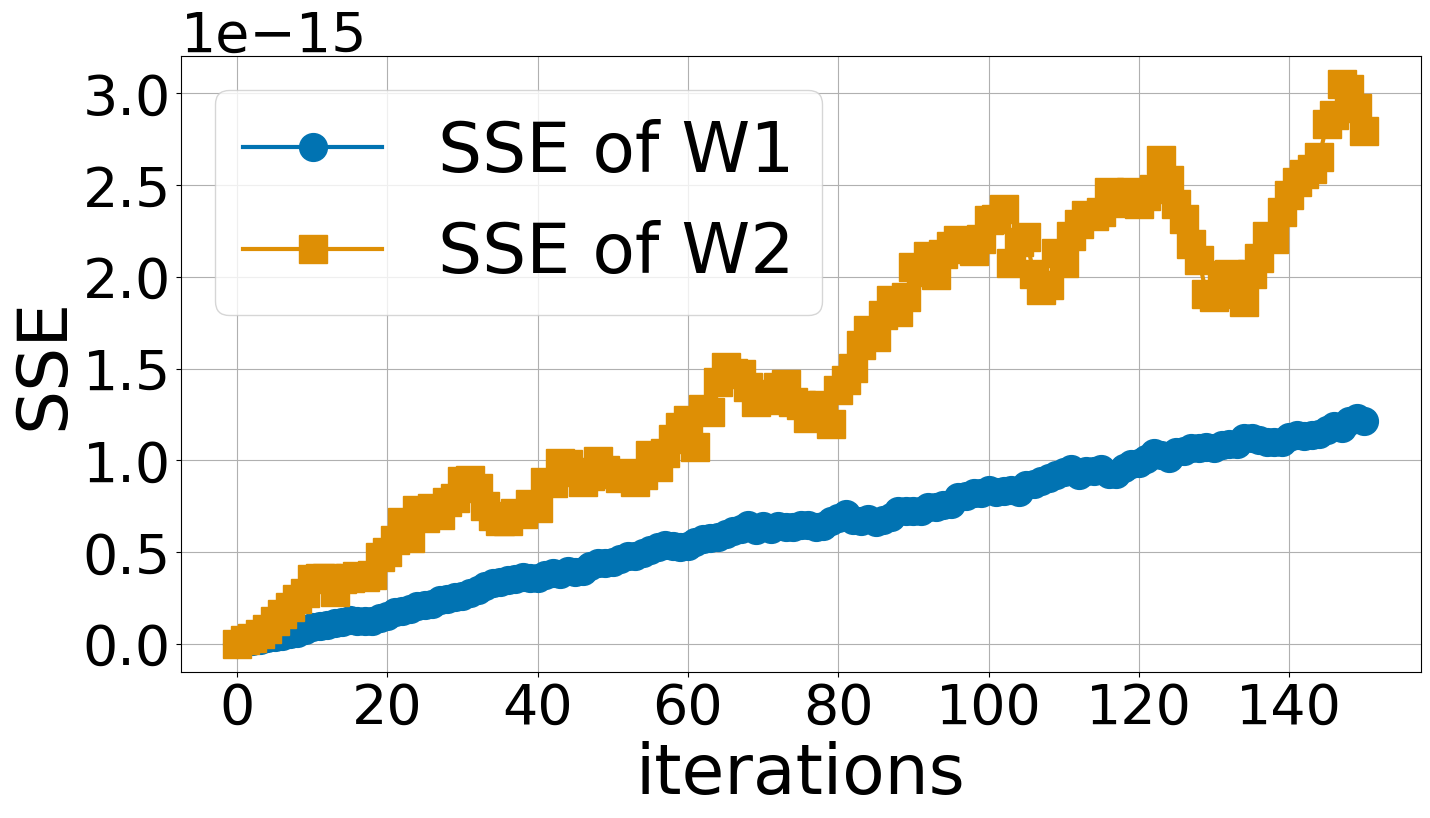

In [540]:
import matplotlib.pyplot as plt

plt.rcParams["xtick.labelsize"] = 40
plt.rcParams["ytick.labelsize"] = 40
plt.figure(figsize=(16,8))
plt.plot(list(range(n_epochs+1)), W1_dif, '#0173b2',linewidth=3, marker='o', markersize=20, label='SSE of W1')
plt.plot(list(range(n_epochs+1)), W2_dif, '#de8f05',linewidth=3, marker='s', markersize=20, label='SSE of W2')
# Sum of Squared Errors
# plt.title('Sum of Squared Errors (SSE) between \nautograd and the method using Kronecker product', fontsize=30)
plt.xlabel('iterations', fontsize=50)
plt.ylabel('SSE', fontsize=50)
plt.legend(loc="best", fontsize=50)
plt.grid()
plt.rcParams.update(plt.rcParamsDefault)
plt.show()

In [529]:
# https://stackoverflow.com/questions/65116715/different-colours-and-alpha-values-based-on-array-values
def get_color_negative(v,
              true_v,
             ):
    pos_color=(0,0,0) # black
    neg_color=(1,0,0) # red
    scaled = np.array(v)
    color_list = []
    i = 0
    for s in scaled:
      if true_v[i] == 1:
        color_list.append(pos_color+(s,))
      else:
        color_list.append(neg_color+(s,))
      i = i + 1
    return color_list

In [530]:
def make_prob_list(out):
  prob_list = []
  for i in range(0,10,1):
    for j in range(i+1,10,1):
      prob_list.append(out[i][j].item())
  return prob_list

In [531]:
temp_A_2=((to_dense_adj(graph.edge_index, max_num_nodes=10)>0)*1)[0]
temp_A_3 = torch.maximum( temp_A_2, temp_A_2.T )
print(temp_A_3)
true_A = temp_A_3

tensor([[0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 1, 0, 0, 0, 0]])


In [532]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000
my_G = nx.complete_graph(10)

def animate(i):
    # G = to_networkx(data, to_undirected=True)
    G = my_G
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=1000,
                    node_color='#56b4e9',
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color=get_color_negative(make_prob_list(outputs[i]),make_prob_list(true_A)),
                    font_size=20
                    )
    plt.title(f'Iteration {i} \n Training loss: {losses_2[i]:.2f}',
              fontsize=30, pad=20)

In [533]:
# fig = plt.figure(figsize=(12, 12))
# plt.axis('off')

# anim = animation.FuncAnimation(fig, animate, \
#             np.arange(0, 150, 1), interval=500, repeat=True)
# html = HTML(anim.to_html5_video())

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


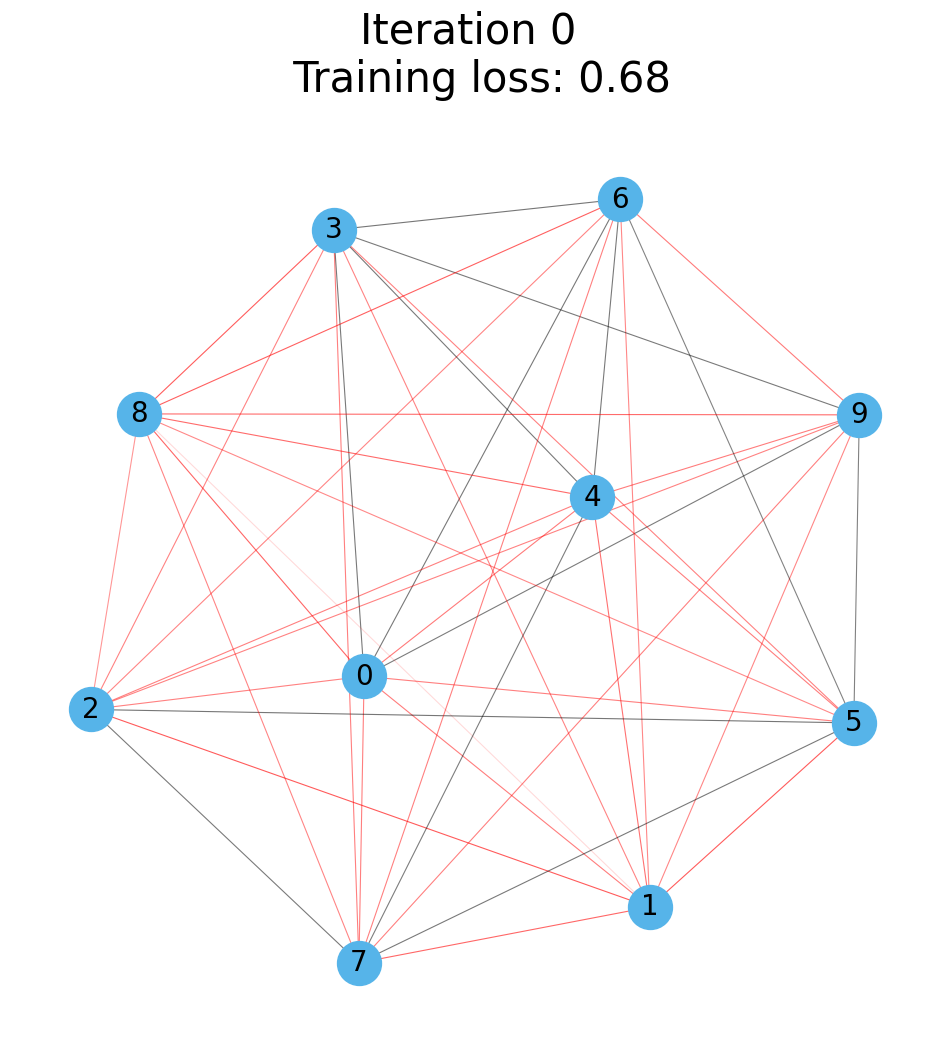

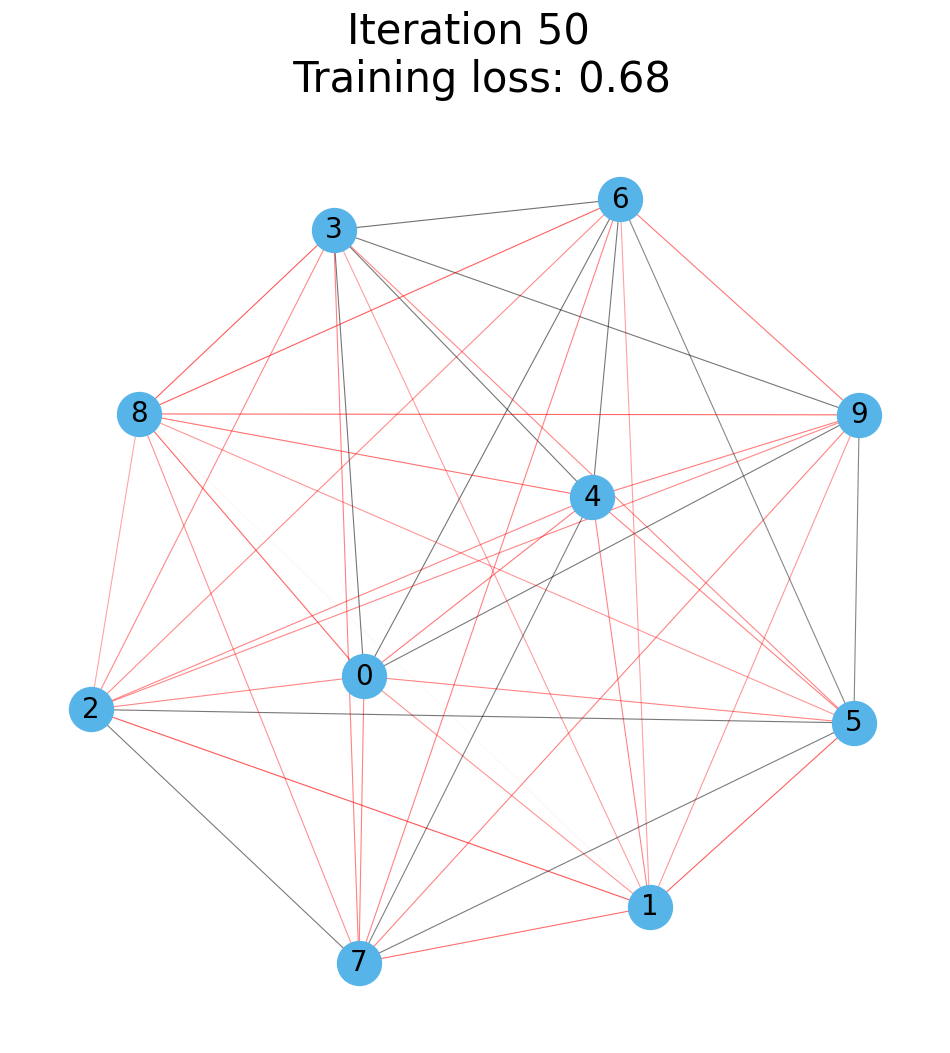

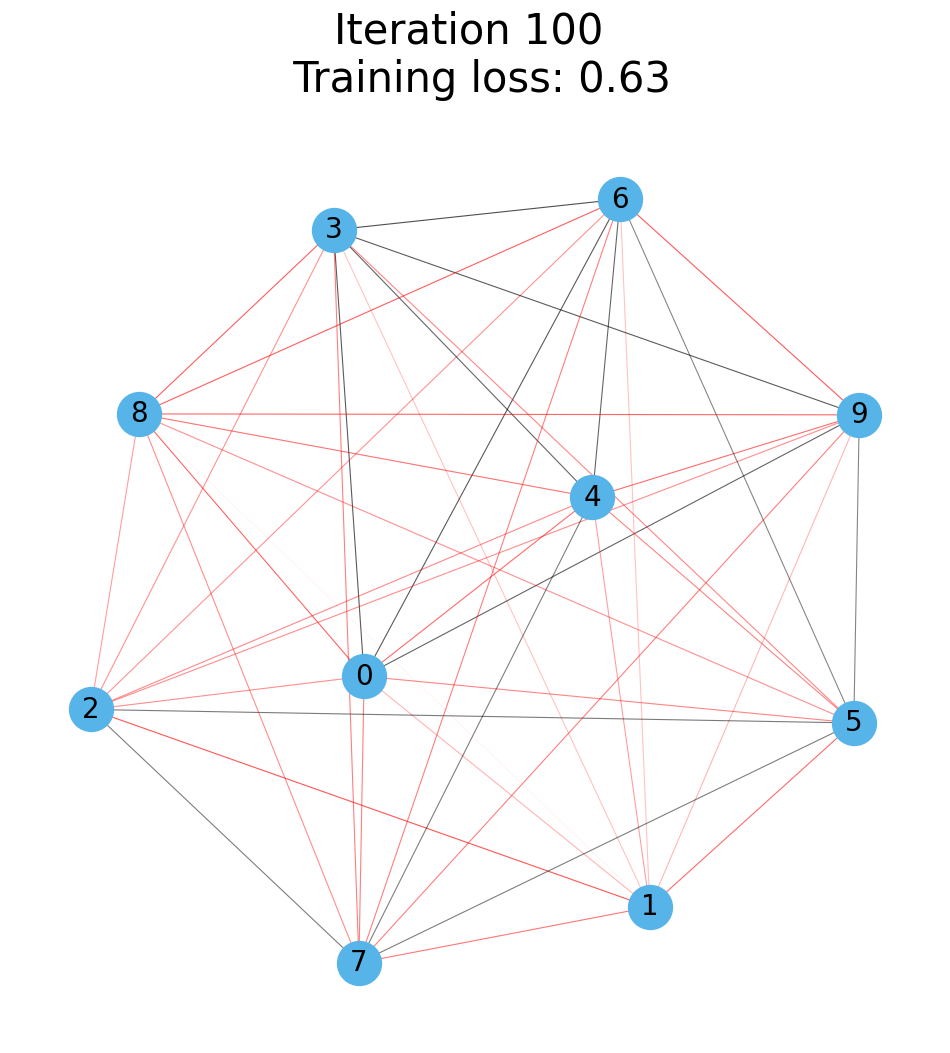

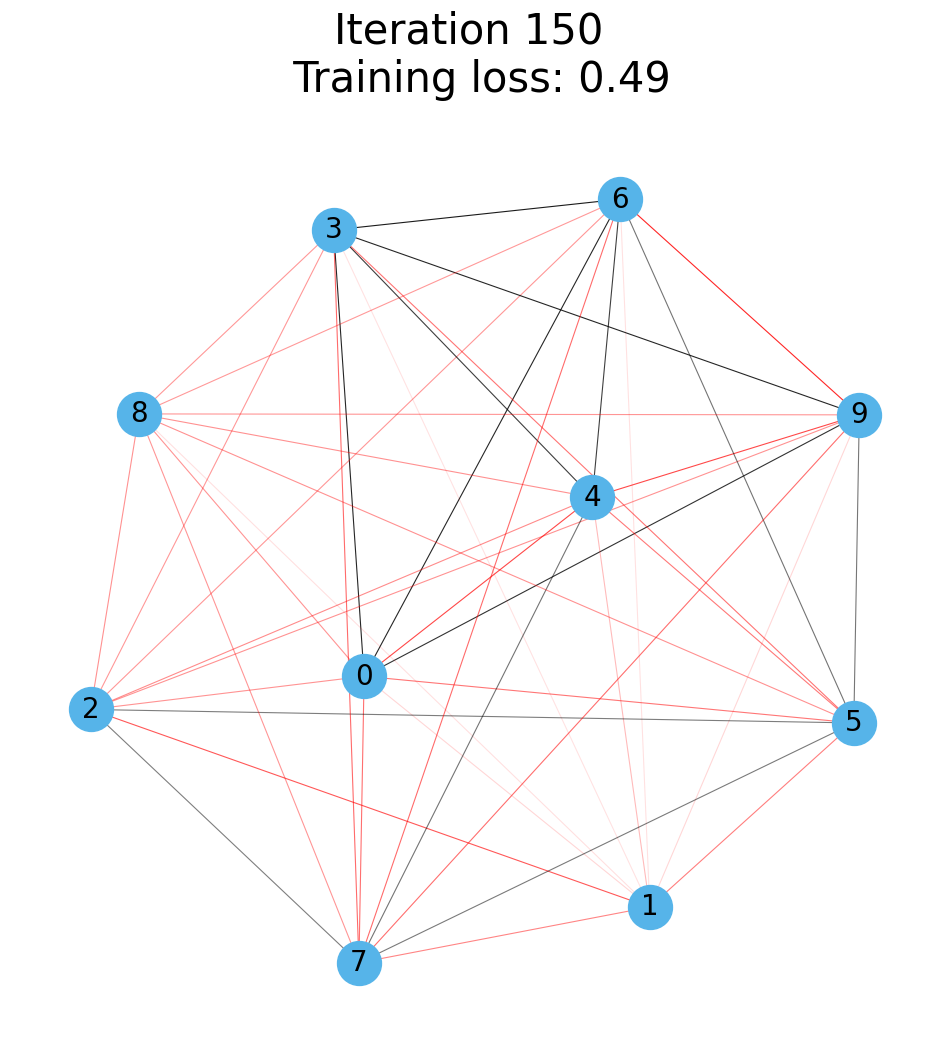

In [534]:
for i in range(0,151,50):
  fig = plt.figure(figsize=(12, 12))
  plt.axis('off')
  animate(i)
  plt.show()

In [535]:
# display(html)

In [536]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000
my_G = nx.complete_graph(10)

def animate_2(i):
    # G = to_networkx(data, to_undirected=True)
    G = my_G
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=1000,
                    node_color='#56b4e9',
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color=get_color_negative(make_prob_list(outputs_2[i]),make_prob_list(true_A)),
                    font_size=20
                    )
    plt.title(f'Iteration {i} \n Training loss: {losses_2[i]:.2f}',
              fontsize=30, pad=20)

In [537]:
# fig = plt.figure(figsize=(12, 12))
# plt.axis('off')

# anim = animation.FuncAnimation(fig, animate, \
#             np.arange(0, 150, 1), interval=500, repeat=True)
# html = HTML(anim.to_html5_video())

In [538]:
# display(html)

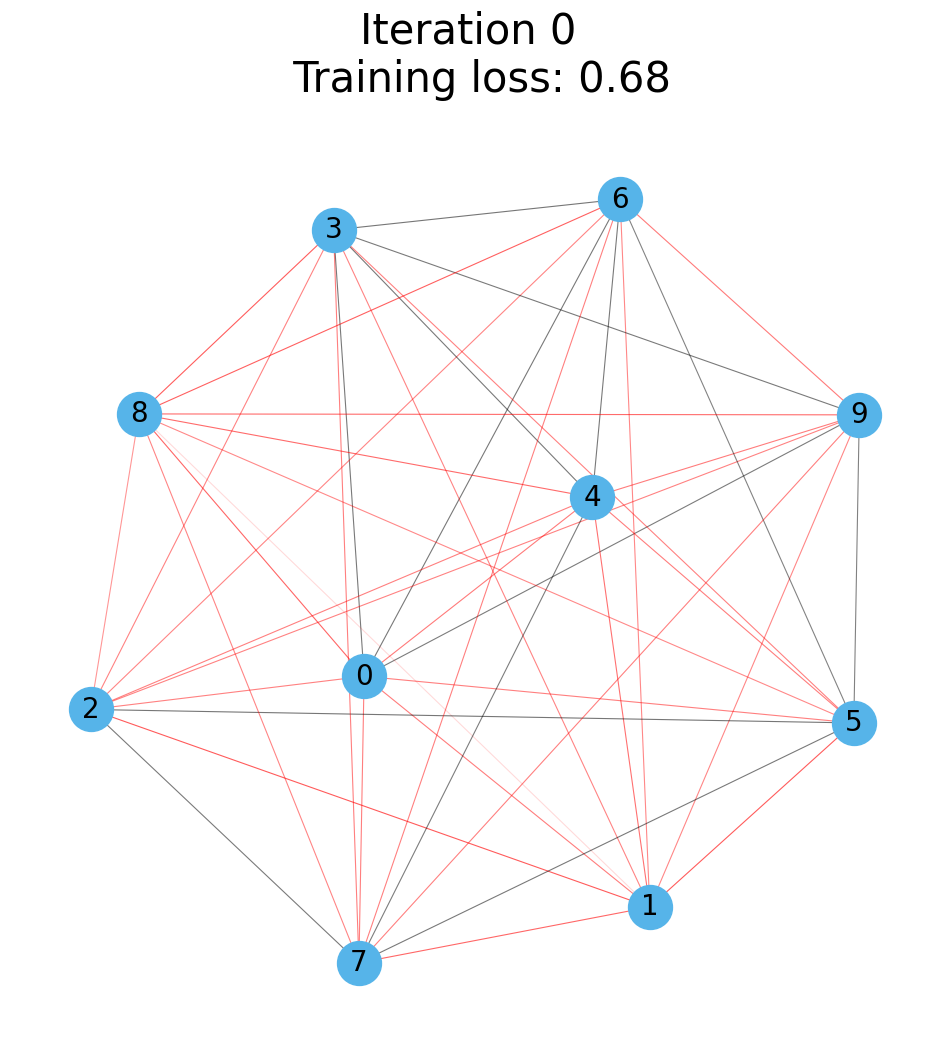

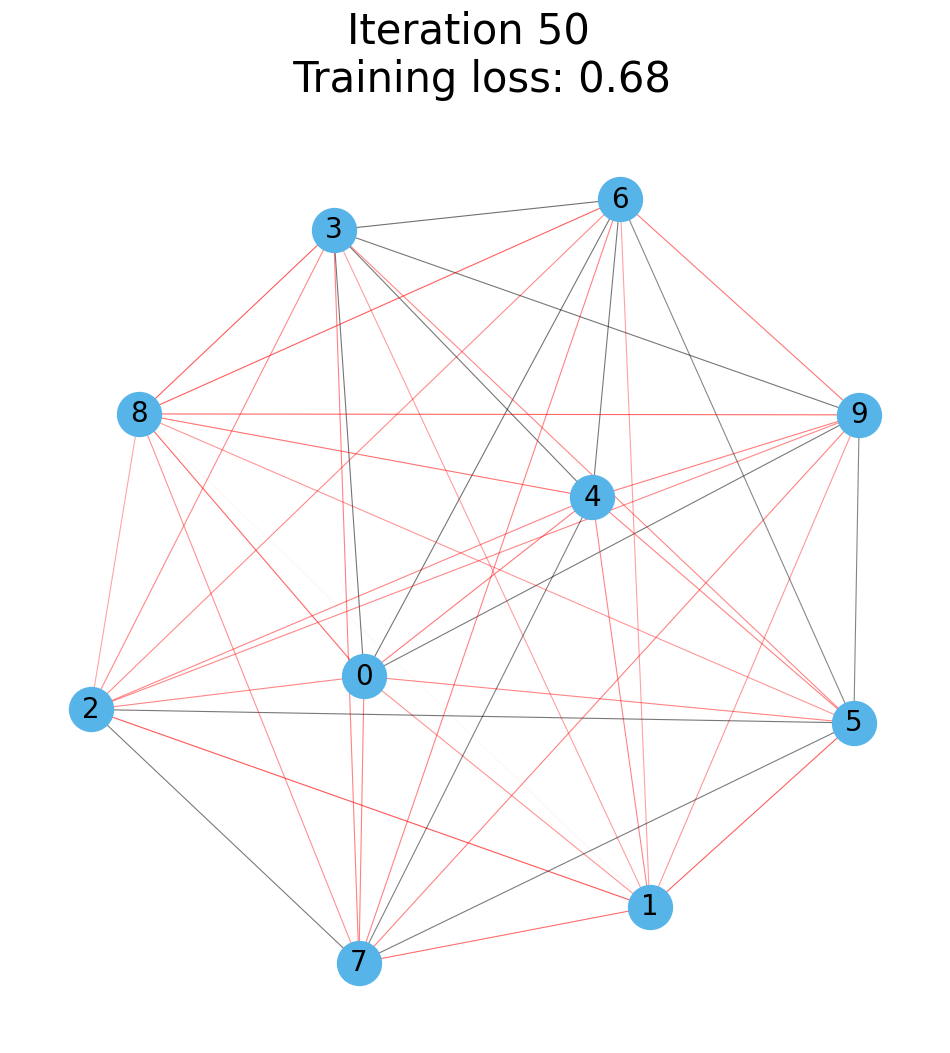

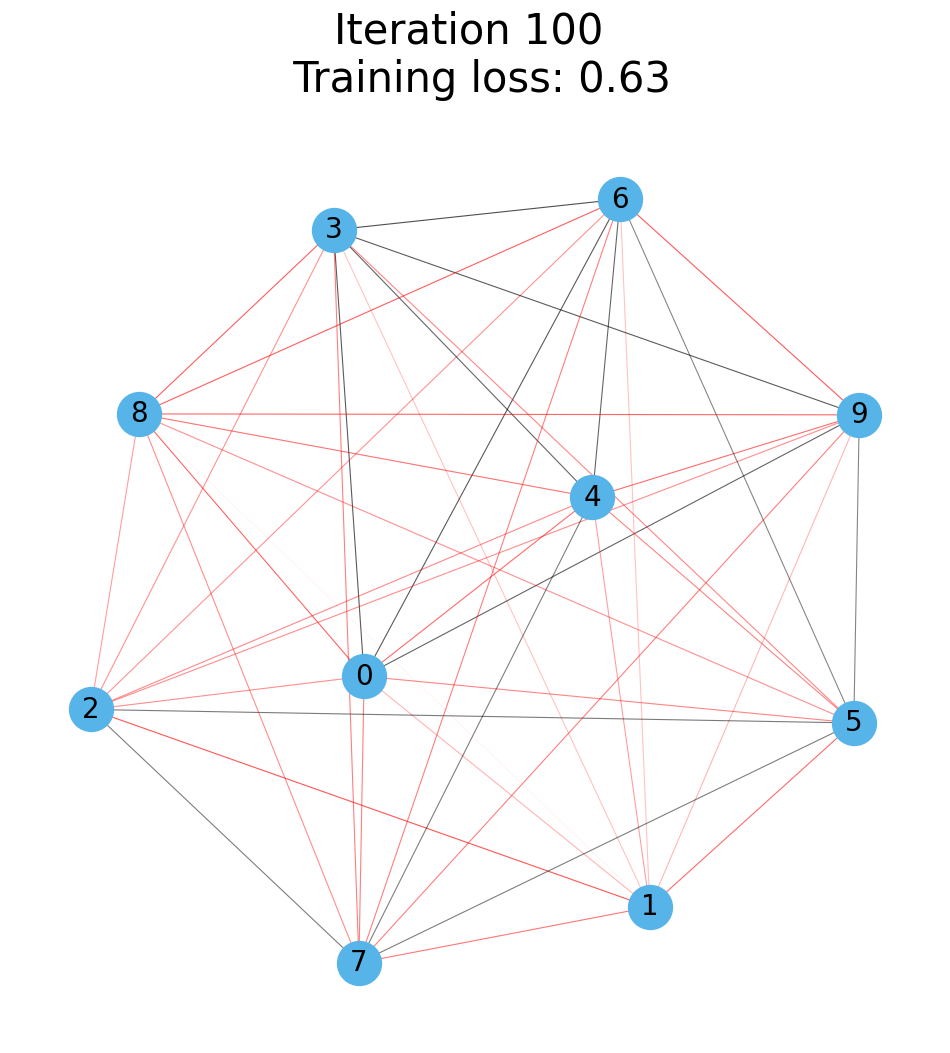

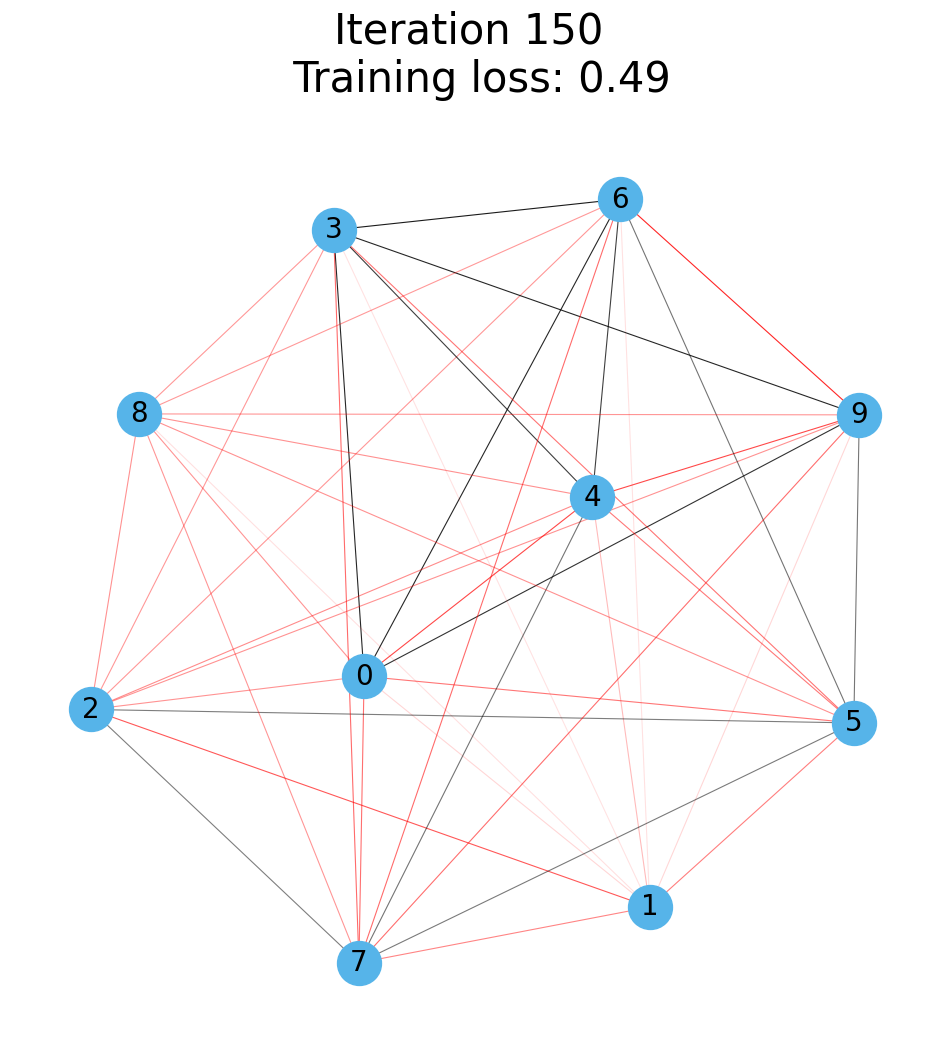

In [539]:
for i in range(0,151,50):
  fig = plt.figure(figsize=(12, 12))
  plt.axis('off')
  animate_2(i)
  plt.show()